# Demonstrate MCMC exploration of posterior distribution of conic parameters

## Imports

We need to explictly add the path to the library since we haven't installed it yet.

In [1]:
import time 
start_time = time.time()
import sys
sys.path.append("../src")
import confit
import numpy as np
import lmfit
from matplotlib import pyplot as plt
import seaborn as sns

## Test data

Symmetric arrangement of 7 points, which I then stretch and distort to make it more interesting.  Using fewer than 7 points is not recommended, although it is possible to ge spectacularly small residuals that way!

In [2]:
xpts, ypts = np.array([1, 2, 3, 4, 5, 6, 7]), np.array([0, 4, 6, 7, 6, 4, 0])
ypts += xpts
xpts *= 3

## Do the fitting

Fit of parabola and a general conic, as in demo01

In [3]:
result_p = confit.fit_conic_to_xy(xpts, ypts, only_parabola=True)
result_e = confit.fit_conic_to_xy(xpts, ypts, only_parabola=False)

First look at the general curve. 

In [4]:
result_e


There are some significant correlations between parameters, which can be better studied via MCMC, which we will do next

## Calculate posterior probability of parameters with emcee



In [5]:
emcee_kws = dict(
    steps=1000, burn=300, thin=20, is_weighted=False, progress=False, workers=16, nan_policy="omit",
)
emcee_params = result_e.params.copy()

In [6]:
result_emcee = lmfit.minimize(confit.residual, args=(xpts, ypts), method='emcee', params=emcee_params, **emcee_kws)

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [94.79605955 97.81846393 88.97396585 95.5115327  90.55303082 92.98322394]


In [7]:
result_emcee

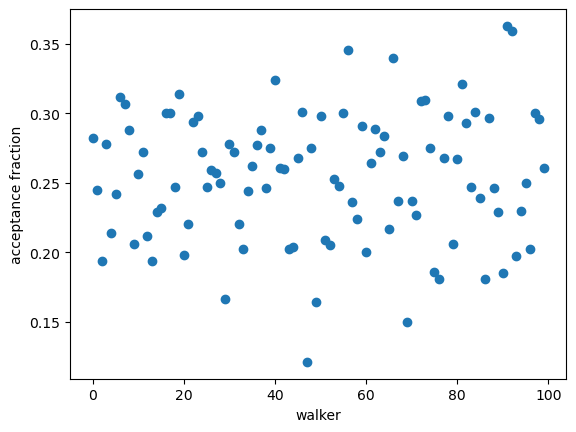

In [8]:
plt.plot(result_emcee.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

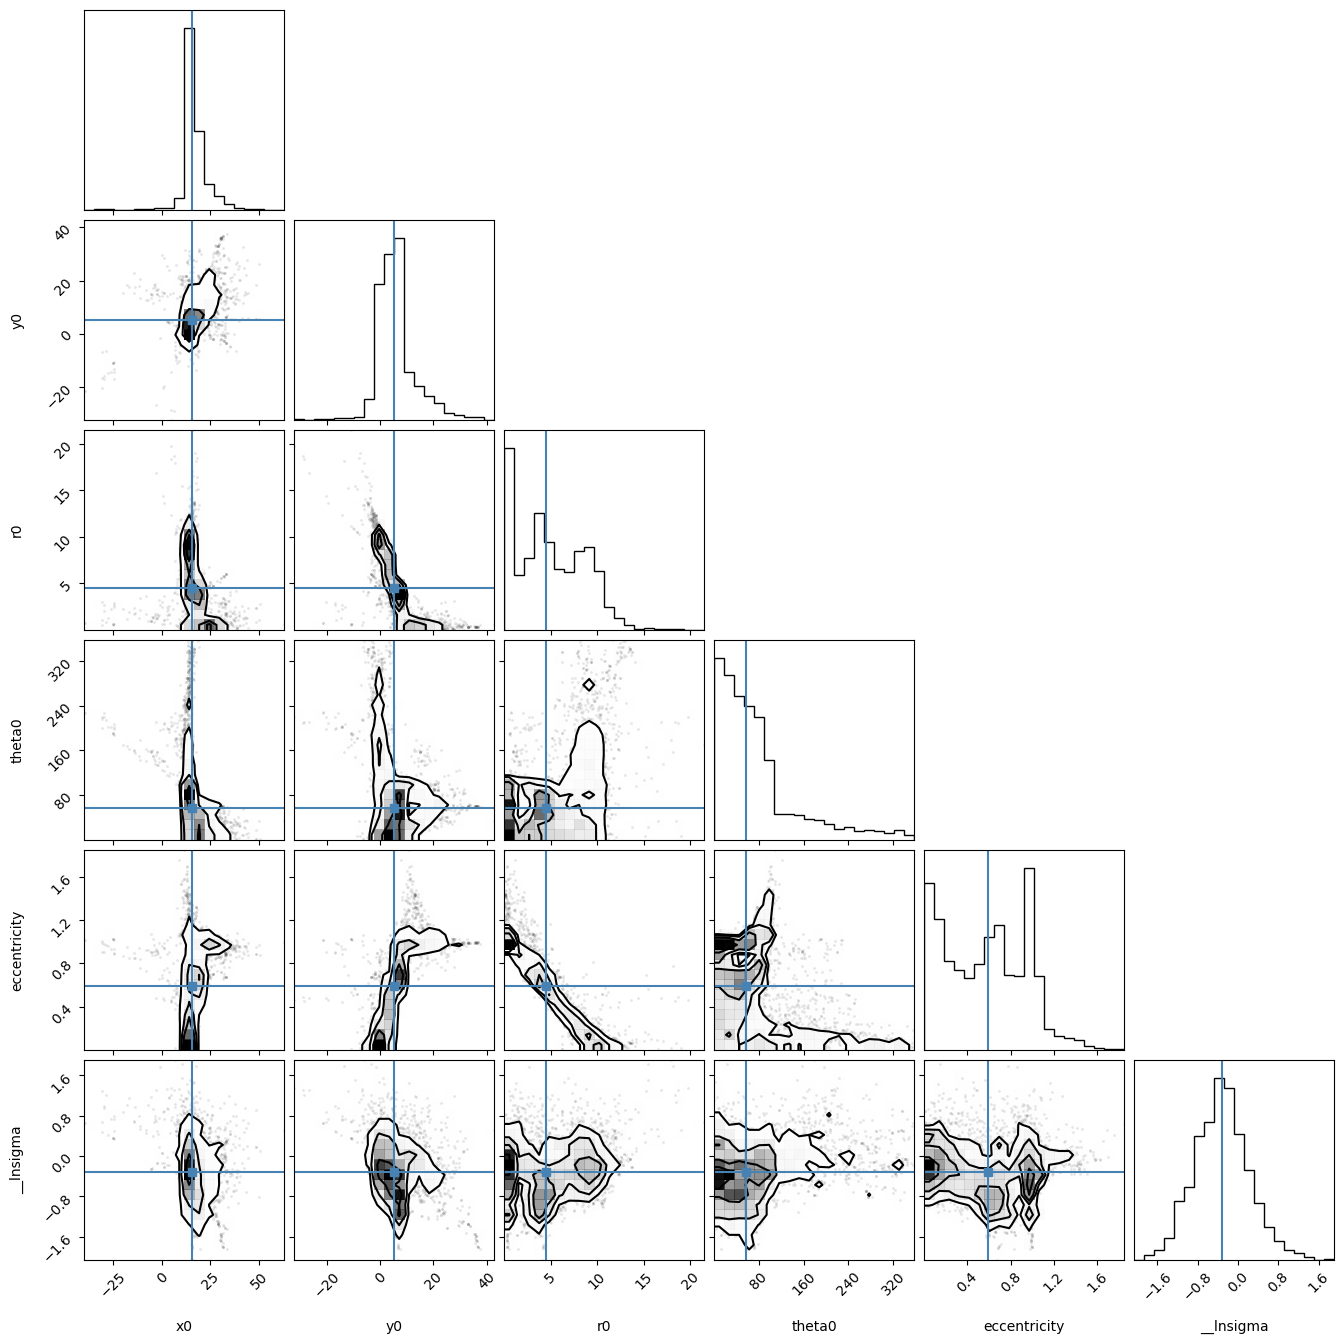

In [9]:
import corner

emcee_plot = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
                           truths=list(result_emcee.params.valuesdict().values()))

In [10]:
result_emcee_p = lmfit.minimize(confit.residual, args=(xpts, ypts), method='emcee', params=result_p.params.copy(), **emcee_kws)

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [115.99255913 113.06031274  83.26242356  85.55463822 129.1824057 ]


In [11]:
result_emcee_p 

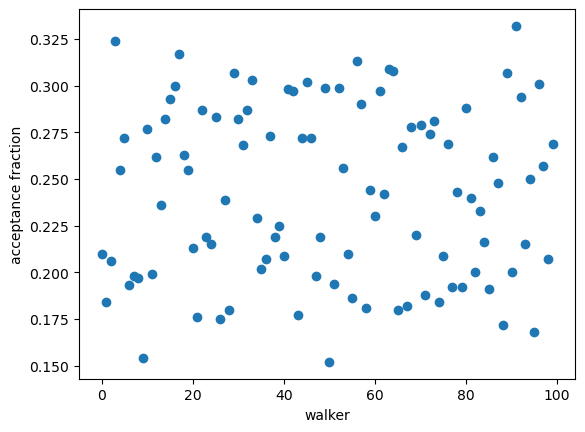

In [12]:
plt.plot(result_emcee_p.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

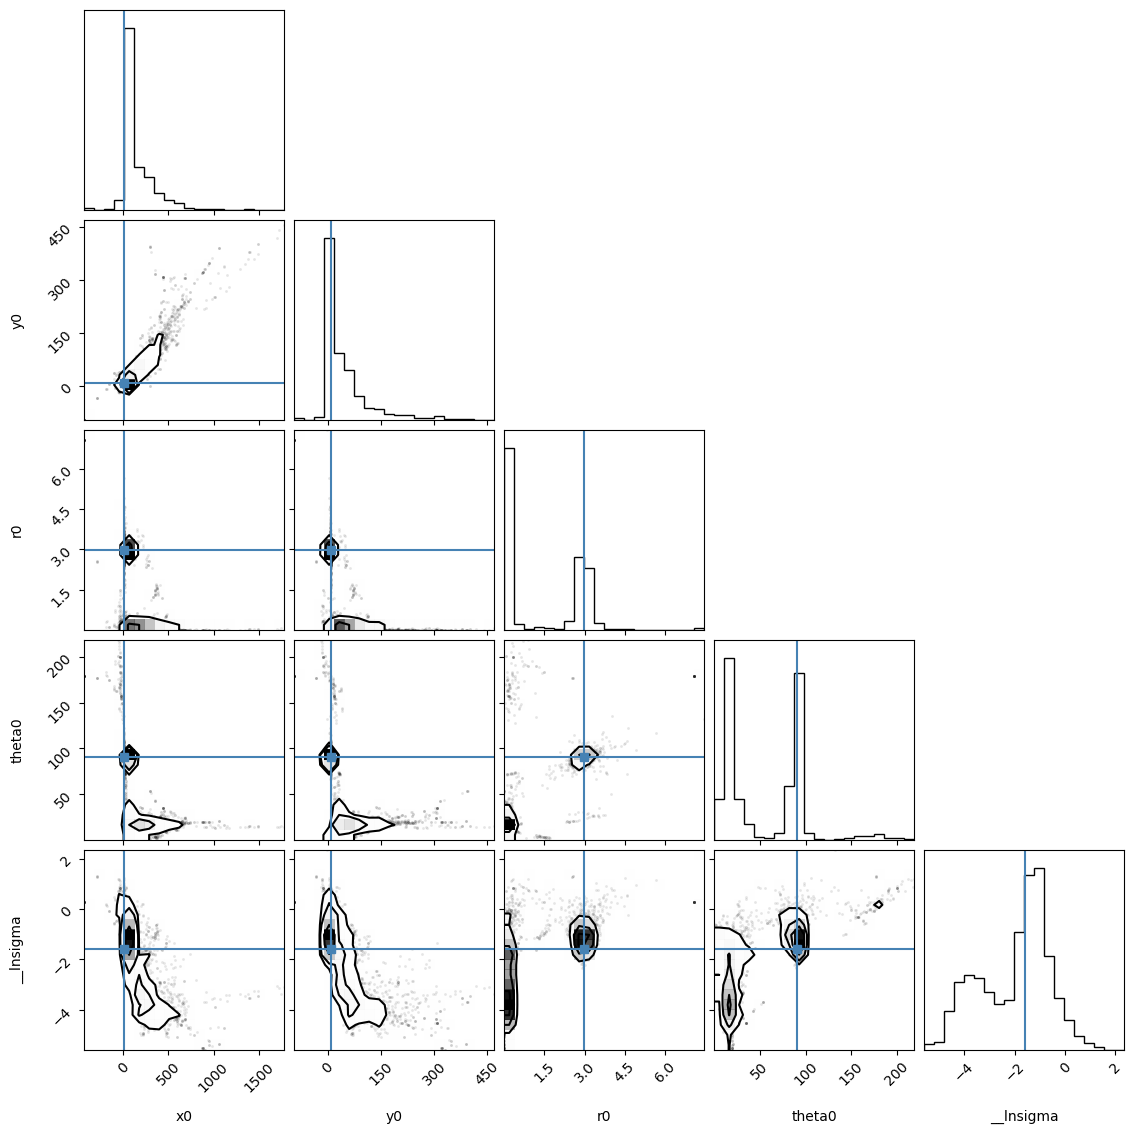

In [13]:
#truths = [result_emcee_p.params.valuesdict()[name] for name in result_emcee_p.var_names]
truths = [result_p.params.valuesdict()[name] for name in result_p.var_names] + [result_emcee_p.params.valuesdict()["__lnsigma"]]
emcee_plot_p = corner.corner(
    result_emcee_p.flatchain, labels=result_emcee_p.var_names, truths=truths,
)

## Plotting the best fit onto the data

In [27]:
best_xy = confit.XYconic(**result_p.params.valuesdict())
print(best_xy)

Conic section curve with focus at (13.960432334044226, 8.230286213583247), scale factor 2.9827089019390476, angle 90.18600416021702, and eccentricity 1.0.


Get a list of dicts with the conic parameters from the MC chain

In [28]:
chain_pars = result_emcee_p.flatchain.drop(columns="__lnsigma").to_dict(orient="records")
len(chain_pars)

3500

Take every 10th row so we have 350 samples in total and get the xy curves for them all

In [29]:
chain_xy = [confit.XYconic(**row, eccentricity=1.0) for row in chain_pars[3::10]]

/Users/will/Dropbox/confit/notebooks/../src/confit.py:102: RuntimeWarning: divide by zero encountered in true_divide
  self.r0


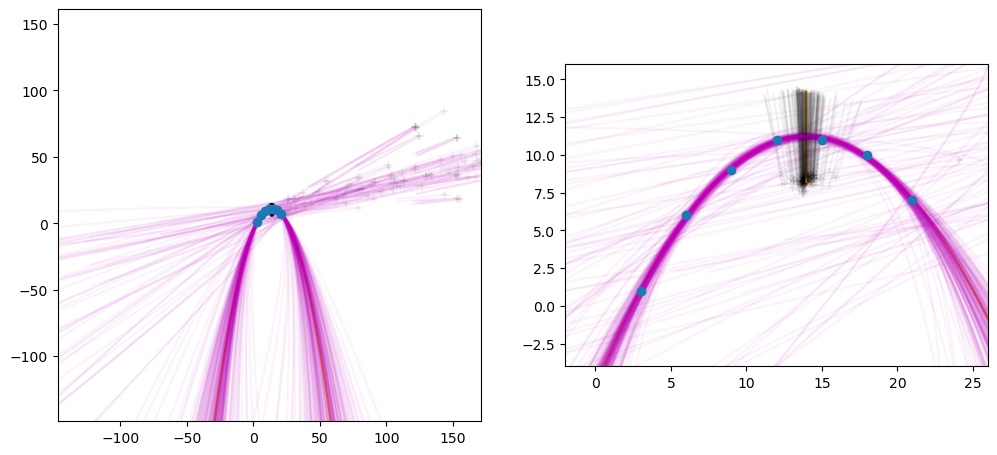

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
for ax in axes:
    ax.scatter(xpts, ypts, zorder=1000)

    c = "orange"
    ax.plot(best_xy.x_pts, best_xy.y_pts, color=c)
    ax.scatter(best_xy.x0, best_xy.y0, marker="+", color=c)
    ax.plot([best_xy.x0, best_xy.x_mirror], [best_xy.y0, best_xy.y_mirror], color=c)

    c = "m"
    alpha = 0.05
    for xy in chain_xy:
        ax.plot(xy.x_pts, xy.y_pts, color=c, alpha=alpha)
        ax.scatter(xy.x0, xy.y0, marker="+", color="k", alpha=alpha)
        ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color="k", alpha=alpha)

    ax.set_aspect("equal")
margin = 150
axes[0].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
margin = 5
axes[1].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

In [18]:
best_xy = confit.XYconic(**result_e.params.valuesdict())
chain_pars = result_emcee.flatchain.drop(columns="__lnsigma").to_dict(orient="records")
chain_xy = [confit.XYconic(**row) for row in chain_pars[1::10]]

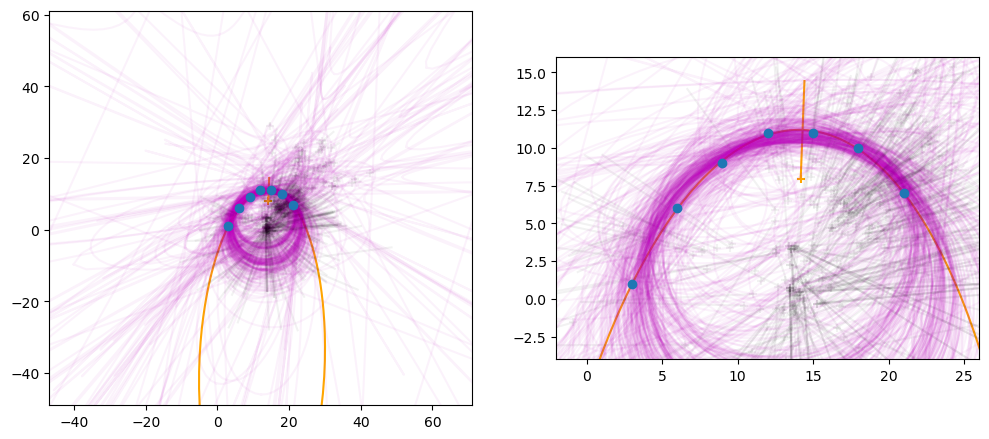

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
for ax in axes:
    ax.scatter(xpts, ypts, zorder=1000)
    c = "orange"
    ax.plot(best_xy.x_pts, best_xy.y_pts, color=c)
    ax.scatter(best_xy.x0, best_xy.y0, marker="+", color=c)
    ax.plot([best_xy.x0, best_xy.x_mirror], [best_xy.y0, best_xy.y_mirror], color=c)

    c = "m"
    alpha = 0.05
    for xy in chain_xy:
        ax.plot(xy.x_pts, xy.y_pts, color=c, alpha=alpha)
        ax.scatter(xy.x0, xy.y0, marker="+", color="k", alpha=alpha)
        ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color="k", alpha=alpha)
    ax.set_aspect("equal")
    
margin = 50
axes[0].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
margin = 5
axes[1].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

## Try and put limits on parameters to avoid the "unreasonable" global minima

In the parabola case, we have a whole bunch of supposedly valid fits that have small value of `r0` (less than 1) coupled with large values of `x0` and `y0` (more than 30) and `theta0` angles around 30 deg. In the figure above, they can be seen to all be well separated from the "good" fits.  So if we put bounds on `r0` we could possibly eliminate them. 

Also, the first time I tried this, it found a whole bunch of garbage solutions, for which the estimate of `__lnsigma` was large, where `__lnsigma` is an extra parameter that gets automatically added by emcee that holds an estimate of the data point uncertainty. Of course, if this is large then any model would fit and so the results are meaningless. We can fix this by explicitly adding the parameter ourselves and putting an upper bound on it. 

In [41]:
new_params = result_p.params.copy()
rscale = new_params["r0"].value
new_params["r0"].set(min=rscale/2, max=rscale*2)
new_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(1))
new_params

name,value,standard error,relative error,initial value,min,max,vary
x0,13.9604323,0.31535709,(2.26%),12.0,-inf,inf,True
y0,8.23028621,0.21719266,(2.64%),9.0,-inf,inf,True
r0,2.98270890,0.15103907,(5.06%),4.279303547652316,1.49135445,5.96541780,True
theta0,90.1860042,2.64713202,(2.94%),93.41881035763075,0.00000000,360.000000,True
eccentricity,1.00000000,0.00000000,(0.00%),1.0,0.00000000,inf,False
__lnsigma,-2.30258509,,,-2.3025850929940455,-6.90775528,0.00000000,True


We got a complaint about the chains being too short, so I have increased to 5000

In [43]:
long_emcee_kws = emcee_kws | dict(steps=5000, burn=1000)
long_emcee_kws

{'steps': 5000,
 'burn': 1000,
 'thin': 20,
 'is_weighted': False,
 'progress': False,
 'workers': 16,
 'nan_policy': 'omit'}

In [44]:
result_emcee_pp = lmfit.minimize(confit.residual, args=(xpts, ypts), method='emcee', params=new_params, **long_emcee_kws)

In [45]:
result_emcee_pp

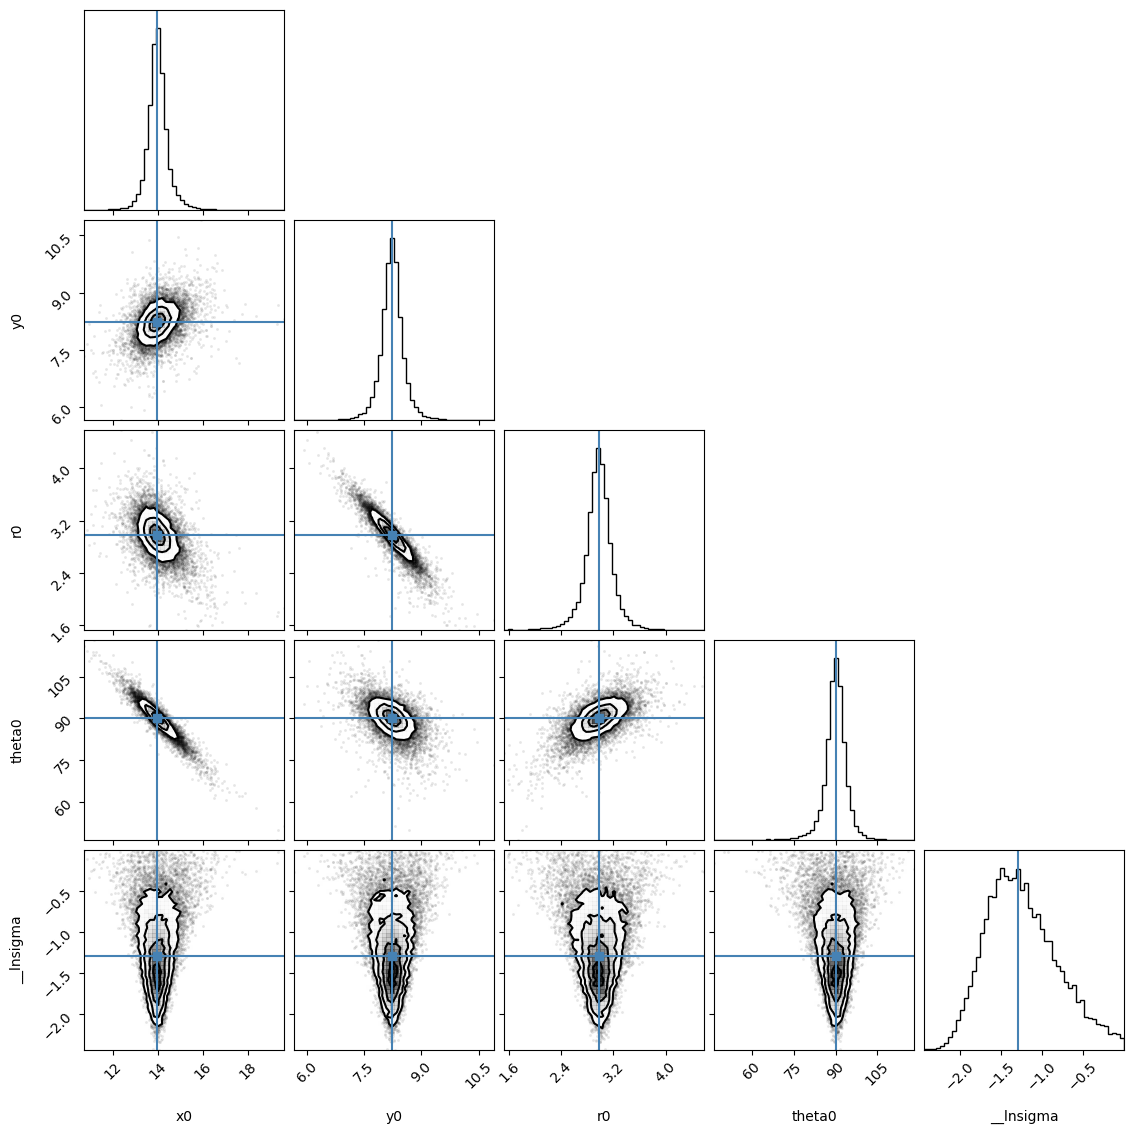

In [46]:
truths = [result_emcee_pp.params.valuesdict()[name] for name in result_emcee_pp.var_names]
emcee_plot_p = corner.corner(
    result_emcee_pp.flatchain, labels=result_emcee_pp.var_names, truths=truths, bins=50,
)

Finally, we have a nice-looking corner plot with elliptical contours!

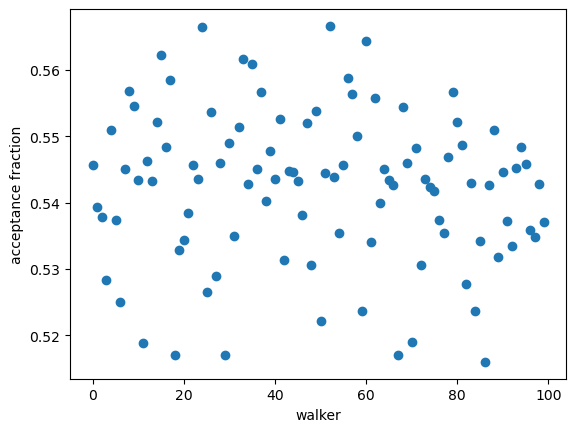

In [52]:
plt.plot(result_emcee_pp.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

And the acceptance fraction looks fine.

In [49]:
len(result_emcee_pp.flatchain)

20000

Now that we have a longer chain, we have to be careful not to take too many samples for the plot, so take every 100th, which should give 200 samples

In [50]:
best_xy = confit.XYconic(**result_p.params.valuesdict())
chain_pars = result_emcee_pp.flatchain.drop(columns="__lnsigma").to_dict(orient="records")
chain_xy = [confit.XYconic(**row, eccentricity=1.0) for row in chain_pars[1::100]]

/Users/will/Dropbox/confit/notebooks/../src/confit.py:102: RuntimeWarning: divide by zero encountered in true_divide
  self.r0
/Users/will/Dropbox/confit/notebooks/../src/confit.py:102: RuntimeWarning: divide by zero encountered in true_divide
  self.r0


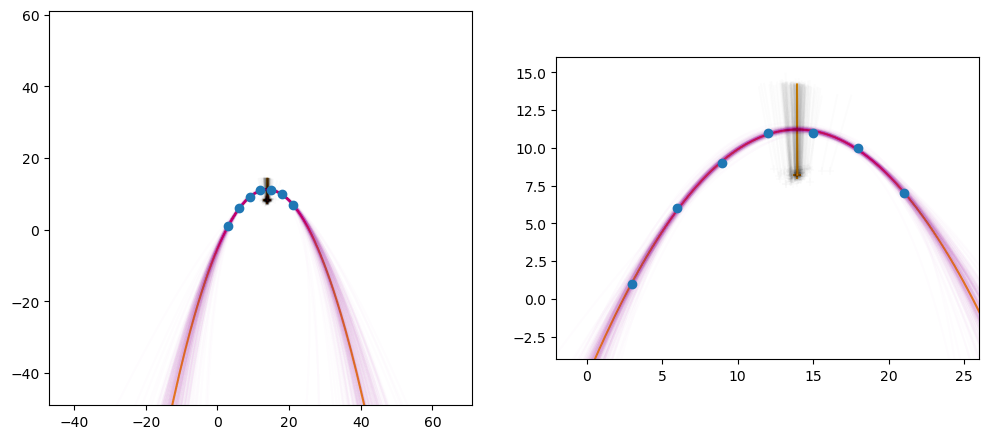

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
for ax in axes:
    c = "orange"
    ax.plot(best_xy.x_pts, best_xy.y_pts, color=c)
    ax.scatter(best_xy.x0, best_xy.y0, marker="+", color=c)
    ax.plot([best_xy.x0, best_xy.x_mirror], [best_xy.y0, best_xy.y_mirror], color=c)

    c = "m"
    alpha = 0.01
    for xy in chain_xy:
        ax.plot(xy.x_pts, xy.y_pts, color=c, alpha=alpha)
        ax.scatter(xy.x0, xy.y0, marker="+", color="k", alpha=alpha)
        ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color="k", alpha=alpha)
    ax.scatter(xpts, ypts, zorder=1000)
    ax.set_aspect("equal")
    
margin = 50
axes[0].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
margin = 5
axes[1].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

So now we have a nice clean set of parabola fits. We can see visually the correlation between `x0` and `theta0`: as the focus moves left or right, the parabola axis has to swing around to accomodate the data points. Similarly, the correlation between `y0` and `r0` is due to the vertical orientation of the axis. 

## Execution time for notebook

In [26]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 51.86462616920471 seconds ---
